In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Regularized Word Embeddings in Text Classification
## Sections 3 and 4:  Document Similarity, and Word Embedding Regularization

We consider three document representations:

- Vector Space Model (VSM)
- Soft Vector Space Model (Soft VSM)

We consider four term weighting schemes:

- Bag of Words (BOW)
- TF-IDF

And we consider two similarities:

- Inner Product (IP)
- Word Mover's Distance (WMD)

Not all combinations of document representations, term weighting schemes, and similarities are supported by `dataset.py`:

| ↓ Weights, Space and similarity → | VSM IP | VSM WMD | Soft VSM IP |
|--|--|--|--|
| BOW | ✅ | ✅ | ❌ |
| TF-IDF | ✅ | ❌ | ✅ |

## Section 5: Evaluation

We compare the individual document representations, term weighing schemes, and similarities using $k$NN on standard datasets.

In [2]:
configurations = [
    # ('random', 'random', 'random', 'random'),
    ('vsm', 'bow', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32),
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1),
    ('vsm', 'bow', 'wmd', 32),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1),
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32),
]
configuration_names = {
    ('random', 'random', 'random', 'random'): 'Random',
    ('vsm', 'bow', 'inner_product', 32): 'BoW',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 32): 'Soft VSM',
    ('dense_soft_vsm', 'tfidf', 'inner_product', 1): 'Soft VSM (quan.)',
    ('vsm', 'bow', 'wmd', 32): 'WMD',
    ('vsm', 'bow', 'wmd', 1): 'WMD (quant.)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 32): r'Soft VSM (ortho.)',
    ('sparse_soft_vsm', 'tfidf', 'inner_product', 1): r'Soft VSM (quan., ortho.)',
}

There are several parameters that are tuned by grid search.

- Soft VSM (sparse):
    - `symmetric`${}\in\{$ `True`, `False` $\}$
    - `dominant`${}\in\{$ `True`, `False` $\}$
    - `tfidf`${}\in\{$ `<TfidfModel>`, `None` $\}$
    - `nonzero_limit`${}\in\{100, 200, 400, 800\}$
    - `threshold`${}\in\{-1.0, -0.5, 0.0, 0.5\}$
    - `exponent`${}\in\{1, 2, 3, 4\}$
- TFIDF:
    - `slope`${}\in\{0.0, 0.1, \ldots, 1.0\}$
- $k$NN:
    - $k\in\{1,3,\ldots,19\}$.

In [3]:
parameters = [
    'symmetric',
    'dominant',
    'tfidf',
    'nonzero_limit',
    'threshold',
    'exponent',
    'slope',
    'k',
]

   
### Subsection 5.2: Datasets


In [4]:
from math import sqrt

from common import ClassificationResult

dataset_names = []
results = dict()

def load_results(name):
    """Loads classification results for a given dataset.
    
    Parameters
    ----------
    name : str
        The name of a dataset.
    """

    dataset_names.append(name)
    results[name] = dict()
    datasets = None
    for configuration in configurations:
        basename = '{}-{}'.format(name, '-'.join(map(str, configuration)))
        try:
            result = ClassificationResult.from_file(basename)
        except IOError:
            if datasets is None:
                import dataset
                dataset_loader = dataset.__dict__['load_{}'.format(name)]
                datasets = dataset_loader()
            train, validation, test = datasets
            result = train.classify(validation, test, *configuration)
            result.to_file(basename)
        results[name][configuration] = result

For classification, we use the following datasets:


- [BBCSport][BBC] (2005, 255K, 737 documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [5]:
load_results('bbcsport')

2019-08-21 11:30:59,294 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-inner_product-32.pkl.xz.
2019-08-21 11:30:59,296 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-08-21 11:30:59,297 : INFO : Loading a classification result from file results/classification-bbcsport-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,298 : INFO : Loading a classification result from file results/classification-bbcsport-vsm-bow-wmd-32.pkl.xz.
2019-08-21 11:30:59,299 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,311 : INFO : Loading a classification result from file results/classification-bbcsport-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.


- [TWITTER][] (2011, 160K, 6.4k documents subsampled to 3,108 documents, *free*)

 [TWITTER]: https://web.archive.org/web/20180328044709/www.sananalytics.com/lab/twitter-sentiment/ (Sanders Analytics - Twitter Sentiment Corpus)

In [6]:
load_results('twitter')

2019-08-21 11:30:59,450 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-inner_product-32.pkl.xz.
2019-08-21 11:30:59,452 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-08-21 11:30:59,453 : INFO : Loading a classification result from file results/classification-twitter-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,454 : INFO : Loading a classification result from file results/classification-twitter-vsm-bow-wmd-32.pkl.xz.
2019-08-21 11:30:59,455 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,467 : INFO : Loading a classification result from file results/classification-twitter-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.



- [BBC] (2005, 864K, 2.23k documents, *free*)

 [BBC]: http://mlg.ucd.ie/datasets/bbc.html (Insight - BBC Datasets)

In [7]:
# load_results('bbc', load_bbc)


- [OHSUMED][] (1994, 24M, 50.22k documents, *free*)
    - We only use documents in a single category.
    - For computational efficiency, we subsample the dataset, using the first 10 classes.

 [OHSUMED]: http://disi.unitn.it/moschitti/corpora.htm (Donwloadable Corpora)


In [8]:
load_results('ohsumed')

2019-08-21 11:30:59,733 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-inner_product-32.pkl.xz.
2019-08-21 11:30:59,735 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-08-21 11:30:59,736 : INFO : Loading a classification result from file results/classification-ohsumed-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,737 : INFO : Loading a classification result from file results/classification-ohsumed-vsm-bow-wmd-32.pkl.xz.
2019-08-21 11:30:59,738 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,750 : INFO : Loading a classification result from file results/classification-ohsumed-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.



- [Reuters-21578][] (1987, 8.2M, 215.78k documents, *free*)
    - We use the 8-class version with train / test split as described in [Cardoso-Cachopo (2007)][cardosocapocho07].

 [cardosocapocho07]: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.96.7709&rep=rep1&type=pdf (Improving Methods for Single-label Text Categorization)
 [Reuters-21578]: http://www.daviddlewis.com/resources/testcollections/reuters21578/ (Reuters-21578 Text Categorization Test Collection)

In [9]:
load_results('reuters')

2019-08-21 11:30:59,890 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-inner_product-32.pkl.xz.
2019-08-21 11:30:59,891 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-08-21 11:30:59,892 : INFO : Loading a classification result from file results/classification-reuters-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,893 : INFO : Loading a classification result from file results/classification-reuters-vsm-bow-wmd-32.pkl.xz.
2019-08-21 11:30:59,894 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:30:59,906 : INFO : Loading a classification result from file results/classification-reuters-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.



- [AMAZON][] (2015, 20G, 142.8m documents subsampled to 8,000 documents, *free*)
    - We only use the “Books”, “CDs and Vinyl”, “Electronics”, and “Home and Kitchen” categories.

 [AMAZON]: http://jmcauley.ucsd.edu/data/amazon/ (Amazon review data)


In [10]:
load_results('amazon')

2019-08-21 11:31:00,035 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-inner_product-32.pkl.xz.
2019-08-21 11:31:00,037 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-08-21 11:31:00,038 : INFO : Loading a classification result from file results/classification-amazon-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:31:00,039 : INFO : Loading a classification result from file results/classification-amazon-vsm-bow-wmd-32.pkl.xz.
2019-08-21 11:31:00,040 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:31:00,052 : INFO : Loading a classification result from file results/classification-amazon-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.



- [20 Newsgroups][] (1995, 14M, 18.83k documents, *free*)

 [20 Newsgroups]: http://qwone.com/~jason/20Newsgroups/ (Home Page for 20 Newsgroups Data Set)

In [11]:
load_results('20news')

2019-08-21 11:31:00,171 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-inner_product-32.pkl.xz.
2019-08-21 11:31:00,172 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-32.pkl.xz.
2019-08-21 11:31:00,173 : INFO : Loading a classification result from file results/classification-20news-dense_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:31:00,175 : INFO : Loading a classification result from file results/classification-20news-vsm-bow-wmd-32.pkl.xz.
2019-08-21 11:31:00,176 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-1.pkl.xz.
2019-08-21 11:31:00,187 : INFO : Loading a classification result from file results/classification-20news-sparse_soft_vsm-tfidf-inner_product-32.pkl.xz.


## Section 6: Results
 
Useful links:

- [Monochrome (Black & white) plots in matplotlib](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)
- [Add confidence interval on barplot](https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/)

In [12]:
!make figures

make: 'figures' is up to date.


### Figure 2: 95% interval estimates for the $k$NN test error on six text classification datasets.

2019-08-21 11:31:01,141 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


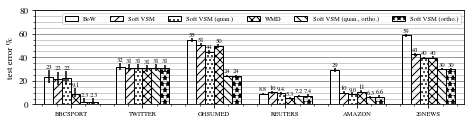

In [13]:
%matplotlib inline

from itertools import chain, cycle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


def flip(items, ncol):
    return chain(*[items[i::ncol] for i in range(ncol)])

num_bars = len(configurations)
num_datasets = len(dataset_names)
bar_width = 1.0 / (num_bars + 2)
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            100 * (1.0 - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1]),
        )
        for name in dataset_names
    )
    for configuration in configurations
))))
bar_xs = [
    np.arange(num_datasets) + bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]
hatches = (' ', '///', '...', 'xxx', '\\\\\\', '**', 'xx', '.', '*', 'o', 'O')

rcParams['font.size'] = 9
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'TeX Gyre Termes']
# plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(6.68, 1.8))
# fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', yerr=yerr, hatch=hatch, capsize=0, label=label)
    for x, y, yerr_upper in zip(x, y, yerr_upper):
        plt.text(
            x=x - (0.45 if y < 10 else 0.35) * bar_width,
            y=y + yerr_upper + 1.5,
            s='{:.1f}'.format(y) if y < 10 else '{:.0f}'.format(y),
            size=6.5,
        )
    # plt.bar(x, y, width=bar_width, edgecolor='black', yerr=yerr, capsize=0, label=label)

handles, labels = ax.get_legend_handles_labels()
ncol = num_bars
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol, prop={'size': 6.5})

plt.xticks(bar_xs[num_bars // 2] - 0.5 * bar_width, map(lambda x: x.upper(), dataset_names), size=6.5)
plt.minorticks_on()
plt.ylabel('test error %')
plt.xlim((-0.5 * (num_bars + 2) * bar_width, num_datasets - 1 + 0.5 * (num_bars + 2) * bar_width))
plt.ylim(0, 80)
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/classification-test_error.pdf')
plt.show()

### Figure 3: Average $k$NN test error compared to BOW.

2019-08-21 11:31:01,982 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


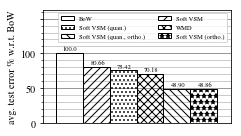

In [14]:
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            100 * (1.0 - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[2] - results[name][configuration].accuracy()[0]),
            100 * (results[name][configuration].accuracy()[0] - results[name][configuration].accuracy()[1]),
        )
        for name in dataset_names
    )
    for configuration in configurations
))))

bar_ys = list(map(lambda x: sum(x) / len(x), bar_ys))
bar_yerrs_lower = list(map(lambda x: sum(x) / len(x), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: sum(x) / len(x), bar_yerrs_upper))

baseline_configuration = ('vsm', 'bow', 'inner_product', 32)
baseline_configuration_index = configurations.index(baseline_configuration)
baseline_y = bar_ys[baseline_configuration_index]

bar_ys = list(map(lambda x: (x / baseline_y, ), bar_ys))
bar_yerrs_lower = list(map(lambda x: (x / baseline_y, ), bar_yerrs_lower))
bar_yerrs_upper = list(map(lambda x: (x / baseline_y, ), bar_yerrs_upper))
# bar_yerrs_lower[baseline_configuration_index] = (0.0, )
# bar_yerrs_upper[baseline_configuration_index] = (0.0, )
bar_xs = [
    bar_width * (bar_number - 0.5 * (num_bars - 1))
    for bar_number in range(num_bars)
]

fig = plt.figure(figsize=(3.45, 2))
# fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', hatch=hatch, capsize=0, label=label)
    # plt.bar(x, y, width=bar_width, edgecolor='black', capsize=0, label=label)
    plt.text(
        x=x - (0.23 if y[0] < 1 else 0.28) * bar_width,
        y=y[0] + 0.04,
        s=('{:.2f}' if y[0] < 1 else '{:.1f}').format(y[0] * 100),
        size=6.5,
    )

handles, labels = ax.get_legend_handles_labels()
ncol = 2
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol, prop={'size': 6.5})

# plt.xticks(
#     np.add(-0.5 * num_bars * bar_width + 0.5 * bar_width, np.arange(num_bars) * bar_width),
#     map(lambda x: configuration_names[x], configurations)
# )
plt.xticks((), ())
plt.yticks((0.0, 0.5, 1.0, 1.5), (0, 50, 100))
plt.minorticks_on()
plt.ylabel('avg. test error % w.r.t. BoW')
plt.xlim((-0.5 * (num_bars + 1) * bar_width, 0.5 * (num_bars + 1) * bar_width))
plt.ylim((0.0, 1.625))
plt.grid(axis='y', which='major', color='k', alpha=0.5)
plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/classification-avg_test_error_ratio.pdf')
plt.show()

### Figure 4: Average document processing speed on one Intel Xeon X7560 2.26 GHz core.

2019-06-25 04:01:00,743 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


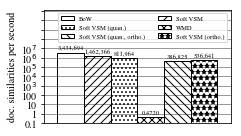

In [15]:
import numpy as np

from common import read_speeds

wmd_num_workers = 64
bar_ys, bar_yerrs_lower, bar_yerrs_upper = list(zip(*map(lambda x: zip(*x), (
    (
        (
            read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[0],
            read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[0] - read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[1],
            read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            
            )[2] - read_speeds(
                (results[name][configuration] for name in dataset_names),
                num_workers=1 if 'wmd' not in configuration else wmd_num_workers,
            )[0],
        ),
    )
    for configuration in configurations
))))

fig = plt.figure(figsize=(3.45, 2))
# fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
for x, y, yerr_lower, yerr_upper, label, hatch in zip(
            bar_xs,
            bar_ys,
            bar_yerrs_lower,
            bar_yerrs_upper,
            map(lambda x: configuration_names[x], configurations),
            cycle(hatches),
        ):
    yerr = (yerr_lower, yerr_upper)
    plt.bar(x, y, width=bar_width, edgecolor='black', color='w', hatch=hatch, capsize=0, label=label)
    plt.text(
        x=x - (0.33 if y[0] < 1 else (0.39 if y[0] < 10**6 else 0.48)) * bar_width,
        y=y[0] * 2,
        s=('{:.4f}' if y[0] < 1 else '{:,.0f}').format(y[0]),
        size=6.5,
    )

handles, labels = ax.get_legend_handles_labels()
ncol = 2
plt.legend(flip(handles, ncol), flip(labels, ncol), loc='best', ncol=ncol, prop={'size': 6.5})

plt.xticks((), ())
plt.yscale('log')
plt.yticks(
    (10.0**np.arange(-1, 12)),
    ('0.1', '1', '10', '100', '10$^3$', '10$^4$', '10$^5$', '10$^6$', '10$^7$'),
)
plt.minorticks_on()
plt.ylabel('doc. similarities per second')
plt.xlim((-0.5 * (num_bars + 1) * bar_width, 0.5 * (num_bars + 1) * bar_width))
plt.grid(axis='y', which='major', color='k', alpha=0.5)
# plt.grid(axis='y', which='minor', color='k', alpha=0.25)
plt.tight_layout()
plt.ylim((0.1, 10**11.1))
plt.savefig('figures/classification-avg_speed.pdf')
plt.show()

### Paragraph: Significance Testing

In [16]:
from itertools import product, combinations

from common import f_test

kwargs = list(product(dataset_names, combinations(configurations, 2)))
result_pairs = map(lambda x: (results[x[0]][x[1][0]], results[x[0]][x[1][1]]), kwargs)
test_results = f_test(result_pairs)

for (dataset, (first_configuration, second_configuration)), test_result in zip(kwargs, test_results):
    if not test_result:
        first_configuration_name = configuration_names[first_configuration]
        second_configuration_name = configuration_names[second_configuration]
        print("Not different mean: {}, {}, {}".format(
            dataset,
            first_configuration_name,
            second_configuration_name,
    ))

Not different mean: bbcsport, Soft VSM, Soft VSM (quan.)
Not different mean: bbcsport, Soft VSM (quan., ortho.), Soft VSM (ortho.)
Not different mean: twitter, Soft VSM, Soft VSM (quan.)
Not different mean: twitter, Soft VSM (quan.), Soft VSM (quan., ortho.)
Not different mean: ohsumed, Soft VSM (quan., ortho.), Soft VSM (ortho.)


### Table 2: Optimal parameter values for the soft VSM with orthogonalized word embeddings.

In [17]:
dataset_params = {}
for name in dataset_names:
    result = results[name]['sparse_soft_vsm', 'tfidf', 'inner_product', 32]
    dataset_params[name] = {}
    for parameter, value in result.params.items():
        if parameter in parameters:
            dataset_params[name][parameter] = value
dataset_params

{'20news': {'dominant': False,
  'exponent': 3,
  'k': 1,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': False,
  'tfidf': True,
  'threshold': -1.0},
 'amazon': {'dominant': True,
  'exponent': 4,
  'k': 17,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0},
 'bbcsport': {'dominant': True,
  'exponent': 2,
  'k': 1,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0},
 'ohsumed': {'dominant': True,
  'exponent': 4,
  'k': 11,
  'nonzero_limit': 200,
  'slope': 0.0,
  'symmetric': False,
  'tfidf': True,
  'threshold': -1.0},
 'reuters': {'dominant': True,
  'exponent': 4,
  'k': 19,
  'nonzero_limit': 100,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0},
 'twitter': {'dominant': False,
  'exponent': 2,
  'k': 13,
  'nonzero_limit': 400,
  'slope': 0.0,
  'symmetric': True,
  'tfidf': True,
  'threshold': -1.0}}

### Table 3: Optimal parameter values for all document similarities.

In [18]:
parameter_frequencies = {}
for name in dataset_names:
    for result in results[name].values():
        for parameter, value in result.params.items():
            if parameter not in parameters:
                continue
            if parameter not in parameter_frequencies:
                parameter_frequencies[parameter] = {}
            if value not in parameter_frequencies[parameter]:
                parameter_frequencies[parameter][value] = 0
            parameter_frequencies[parameter][value] += 1
parameter_frequencies

{'dominant': {False: 5, True: 7},
 'exponent': {1: 2, 2: 6, 3: 1, 4: 3},
 'k': {1: 9, 3: 2, 5: 2, 7: 2, 9: 3, 11: 8, 13: 2, 15: 1, 17: 3, 19: 4},
 'nonzero_limit': {100: 7, 200: 2, 400: 2, 800: 1},
 'slope': {0.0: 24},
 'symmetric': {False: 4, True: 8},
 'tfidf': {False: 3, True: 9},
 'threshold': {-1.0: 12}}

### Figure 1: The $k$NN confusion matrix and t-SNE document visualization for the soft VSM with non-regularized (50.71% test error, left) and regularized (24.14% test error, right) word embeddings on the OHSUMED dataset.

In [19]:
from itertools import repeat
import lzma
import pickle

from gensim.matutils import corpus2csc, unitvec
from gensim.models import TfidfModel
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing as preprocessing
from scikits.sparse.cholmod import cholesky

import dataset
from dataset import common_dictionary, common_embedding_matrices, pivot_worker, translate_document_worker

params = dict(results['ohsumed']['sparse_soft_vsm', 'tfidf', 'inner_product', 1].params)
params.update({'symmetric': True, 'dominant': True})
basename = '{num_bits}-{tfidf}-{symmetric}-{dominant}-{nonzero_limit}-{threshold}-{exponent}'.format(**params)

try:
    with lzma.open('matrices/cholesky-{}.pkl.xz'.format(basename), 'rb') as f:
        sparse_embedding_matrix = pickle.load(f)
except IOError:
    with lzma.open('matrices/termsim-{}.pkl.xz'.format(basename), 'rb') as f:
        sparse_embedding_matrix = pickle.load(f)
    with lzma.open('matrices/cholesky-{}.pkl.xz'.format(basename), 'wb') as f:
        sparse_embedding_matrix = cholesky(sparse_embedding_matrix).L()
        pickle.dump(sparse_embedding_matrix, f)

dense_embedding_matrix = common_embedding_matrices[32]
dense_embedding_matrix = preprocessing.normalize(dense_embedding_matrix, norm='l2')

2019-06-24 22:33:32,683 : INFO : 'pattern' package not found; tag filters are not available for English
2019-06-24 22:33:32,907 : INFO : Loading dataset from file corpora/fil8.pkl.xz.
2019-06-24 22:33:37,307 : INFO : loading projection weights from vectors/1b_1000d_vectors_e10_nonbin
2019-06-24 22:33:37,308 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-24 22:34:29,588 : INFO : loaded (60238, 1000) matrix from vectors/1b_1000d_vectors_e10_nonbin
2019-06-24 22:34:29,590 : INFO : loading projection weights from vectors/32b_200d_vectors_e10_nonbin
2019-06-24 22:34:29,591 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-24 22:34:41,293 : INFO : loaded (60238, 200) matrix from vectors/32b_200d_vectors_e10_nonbin


2019-06-24 22:42:00,605 : INFO : Loading dataset from file corpora/ohsumed_train.pkl.xz.
2019-06-24 22:42:01,274 : INFO : Loading dataset from file corpora/ohsumed_validation.pkl.xz.
2019-06-24 22:42:01,355 : INFO : Loading dataset from file corpora/ohsumed_test.pkl.xz.
2019-06-25 00:25:21,645 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


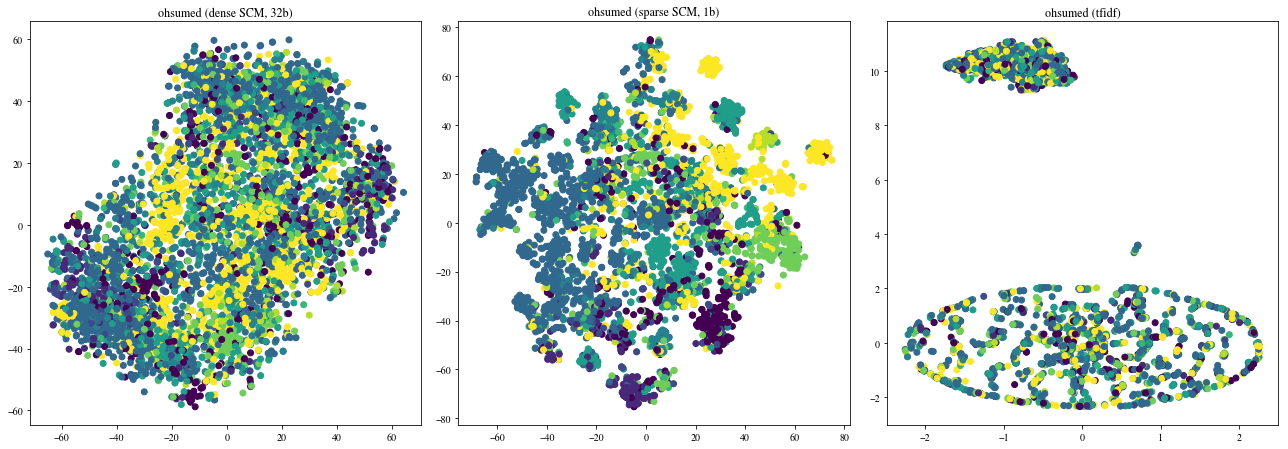

In [20]:
plt.figure(figsize=(18, 6.35))
dataset_name = 'ohsumed'
dataset_loader = dataset.__dict__['load_{}'.format(dataset_name)]
train, validation, test = dataset_loader()
X = test.corpus
Y = np.array(test.target, dtype=int)
tfidf = TfidfModel(dictionary=train.dictionary, smartirs='dtn')
np.random.seed(42)
sample = np.random.choice(len(X), min(len(X), 5000), replace=False)

X_dense_soft_vsm = map(train.dictionary.doc2bow, X)
X_dense_soft_vsm = map(pivot_worker, zip(
    tfidf[X_dense_soft_vsm],
    repeat(1.0),
    repeat(train.avgdl),
))
X_dense_soft_vsm = map(translate_document_worker, zip(
    X_dense_soft_vsm,
    repeat(train.dictionary),
    repeat(common_dictionary),
))
X_dense_soft_vsm = corpus2csc(X_dense_soft_vsm, len(common_dictionary))
X_dense_soft_vsm = scipy.sparse.csc_matrix.dot(
    dense_embedding_matrix.T,
    X_dense_soft_vsm,
).T
X_dense_soft_vsm = PCA(n_components=50).fit_transform(X_dense_soft_vsm)
X_dense_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_dense_soft_vsm)
X_dense_soft_vsm = X_dense_soft_vsm[sample]
Y_dense_soft_vsm = Y[sample]

ax = plt.subplot(1, 3, 1)
ax.set_title('{} (dense SCM, 32b)'.format(dataset_name))
ax.scatter(*X_dense_soft_vsm.T, c=Y_dense_soft_vsm)

X_sparse_soft_vsm = map(train.dictionary.doc2bow, X)
X_sparse_soft_vsm = map(pivot_worker, zip(
    tfidf[X_sparse_soft_vsm],
    repeat(1.0),
    repeat(train.avgdl),
))
X_sparse_soft_vsm = map(translate_document_worker, zip(
    X_sparse_soft_vsm,
    repeat(train.dictionary),
    repeat(common_dictionary),
))
X_sparse_soft_vsm = corpus2csc(X_sparse_soft_vsm, len(common_dictionary))
X_sparse_soft_vsm_norm = X_sparse_soft_vsm.T.dot(sparse_embedding_matrix).multiply(X_sparse_soft_vsm.T).sum(axis=1).T
X_sparse_soft_vsm = X_sparse_soft_vsm.multiply(scipy.sparse.csr_matrix(1 / np.sqrt(X_sparse_soft_vsm_norm)))
X_sparse_soft_vsm = scipy.sparse.csc_matrix.dot(sparse_embedding_matrix.T, X_sparse_soft_vsm).T.todense()
X_sparse_soft_vsm = PCA(n_components=50).fit_transform(X_sparse_soft_vsm)
X_sparse_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_sparse_soft_vsm)
X_sparse_soft_vsm = X_sparse_soft_vsm[sample]
Y_sparse_soft_vsm = Y[sample]

ax = plt.subplot(1, 3, 2)
ax.set_title('{} (sparse SCM, 1b)'.format(dataset_name))
ax.scatter(*X_sparse_soft_vsm.T, c=Y_sparse_soft_vsm)

X_bow = map(train.dictionary.doc2bow, X)
X_bow = map(pivot_worker, zip(
    tfidf[X_bow],
    repeat(1.0),
    repeat(train.avgdl),
))
X_bow = map(translate_document_worker, zip(
    X_bow,
    repeat(train.dictionary),
    repeat(common_dictionary),
))
X_bow = corpus2csc(X_bow, len(common_dictionary)).todense()
X_bow = PCA(n_components=50).fit_transform(X_bow)
X_bow = TSNE(n_components=2, metric='cosine').fit_transform(X_bow)
X_bow = X_bow[sample]
Y_bow = Y[sample]

ax = plt.subplot(1, 3, 3)
ax.set_title('{} (tfidf)'.format(dataset_name))
ax.scatter(*X_bow.T, c=Y_bow)

plt.tight_layout()
plt.savefig('figures/classification-datasets.pdf')
plt.show()

2019-06-25 00:25:23,303 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


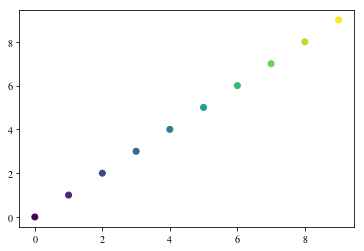

In [21]:
plt.scatter(np.arange(10), np.arange(10), c=np.arange(10))
plt.savefig('figures/classification-dots.pdf')

2019-06-25 00:25:24,029 : WARNING : 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


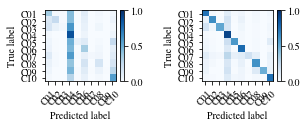

In [22]:
from itertools import product

import numpy as np

from common import ClassificationResult
from mpl_toolkits.axes_grid1 import make_axes_locatable

alpha = 1.0
classes = ('C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10')
tick_marks = np.arange(len(classes))

fig = plt.figure(figsize=(6.5, 1.8))

ax = fig.add_subplot(131)
result = results['ohsumed']['dense_soft_vsm', 'tfidf', 'inner_product', 32]
confusion_matrix = result.confusion_matrix / result.confusion_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix = confusion_matrix**alpha
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = fig.add_subplot(132)
result = results['ohsumed']['sparse_soft_vsm', 'tfidf', 'inner_product', 1]
confusion_matrix = result.confusion_matrix / result.confusion_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix = confusion_matrix**alpha
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar(im, ax=ax)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.tight_layout()
plt.savefig('figures/classification-confusion_matrices.pdf', dpi=600)
plt.show()